# Deep Learning and Neural Network - Question 2
## Arian Firoozi - 810100196
## Arman Majidi - 810100205

# Outline
- [ 0 - Packages ](#0)
- [ 1 - Data Proprocessing ](#1)
- [ 2 - Implementation ](#2)
- [ 3 - Result Analysis ](#3)

---

<a name="0"></a>
## 0 - Packages 

First, let's run the cell below to import all the packages.
- [numpy](https://numpy.org) is the fundamental package for working with matrices in Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [seanborn](https://seaborn.pydata.org) is a Python data visualization library based on matplotlib.
- [tensorflow](https://tensorflow.org) is an end-to-end platform for machine learning.
- [scikit-learn](https://scikit-learn.org) is a Python module for machine learning.
- [albumentations](https://albumentations.ai) is a computer vision tool that boosts the performance of deep convolutional neural networks.

In [1]:
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from collections import Counter
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, Add, Lambda
from tensorflow.keras.models import Model

np.random.seed(42)

---

<a name="1"></a>
## 1 - Dataset Preparation

### ◆ Dataset Choosing

#### load random images with captions

In [2]:
def load_flickr8k_and_show_random_images(image_folder, captions_file, num_images):
    captions = {}
    with open(captions_file, 'r') as file:
        for line in file:
            parts = line.strip().split("#")
            image_file = parts[0].strip()
            caption = parts[1].split('\t')[1].strip()
            if image_file not in captions:
                captions[image_file] = []
            captions[image_file].append(caption)
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
    random_images = random.sample(image_files, min(num_images, len(image_files)))
    plt.figure(figsize=(15, 5))
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("\n".join(captions.get(image_file, ["No caption"])), fontsize=8)
    plt.tight_layout()
    plt.show()

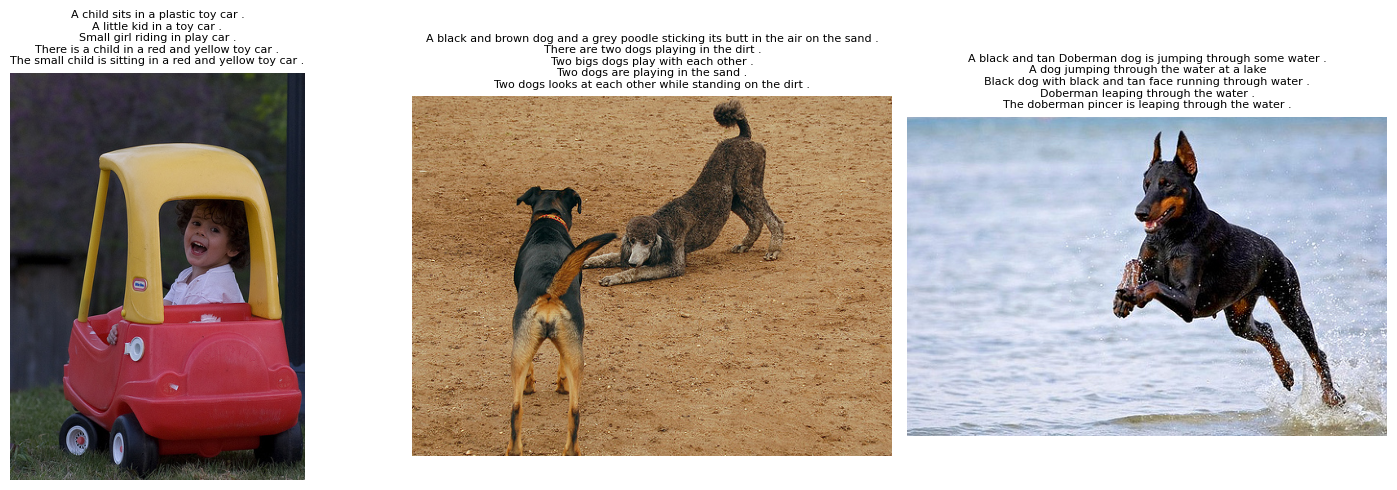

In [3]:
image_folder = "/kaggle/input/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset/"
caption_file = "/kaggle/input/flicker8k-dataset/Flickr8k_text/Flickr8k.token.txt"
load_flickr8k_and_show_random_images(image_folder, caption_file, num_images=3)

---

### ◆ Images Preprocessing

#### resize images

In [4]:
def preprocess_images(image_folder, target_size=(224, 224)):
    resized_images = {}
    for image_file in os.listdir(image_folder):
        if image_file.endswith('.jpg'):
            image_path = os.path.join(image_folder, image_file)
            with Image.open(image_path) as img:
                img_resized = img.resize(target_size)
                img_array = np.array(img_resized)
                resized_images[image_file] = img_array
    return resized_images

In [5]:
images_dict = preprocess_images(image_folder)

#### rescale images

**since EfficientNetB0 uses pictures in range 0-255, we don't change pictures.**

---

### ◆ Captions Preprocessing

In [6]:
def preprocess_captions(captions_file):
    captions_dict = {}
    with open(captions_file, 'r') as file:
        for line in file:
            parts = line.strip().split("#")
            image_file = parts[0].strip()
            if image_file.endswith('.jpg'):
                caption = parts[1].split('\t')[1].strip().lower()
                caption_cleaned = re.sub(r"[^a-z\s]", "", caption)
                if image_file not in captions_dict:
                    captions_dict[image_file] = []
                captions_dict[image_file].append(caption_cleaned)
    return captions_dict

In [7]:
captions_dict = preprocess_captions(caption_file)

#### tokenization

In [8]:
def tokenize_and_map_with_special_tokens(captions_dict, output_file="word_to_id.json"):
    all_words = []
    for captions in captions_dict.values():
        for caption in captions:
            all_words.extend(caption.split())
    word_counter = Counter(all_words)
    special_tokens = ["<pad>", "<sos>", "<eos>", "<unk>"]
    word_to_id = {token: idx for idx, token in enumerate(special_tokens)}
    word_to_id.update({word: idx + len(special_tokens) for idx, (word, _) in enumerate(word_counter.items())})
    tokenized_captions = {}
    for image, captions in captions_dict.items():
        tokenized_captions[image] = [
            [word_to_id["<sos>"]] + 
            [word_to_id.get(word, word_to_id["<unk>"]) for word in caption.split()] + 
            [word_to_id["<eos>"]]
            for caption in captions
        ]
    with open(output_file, "w") as json_file:
        json.dump(word_to_id, json_file, indent=4)
    return word_to_id, tokenized_captions

In [9]:
word_to_id, tokenized_captions = tokenize_and_map_with_special_tokens(captions_dict, "word_to_id.json")

In [10]:
def tokenize_and_pad_captions(captions_dict, word_to_id, caption_len):
    padded_captions = {}
    pad_id = word_to_id["<pad>"]
    sos_id = word_to_id["<sos>"]
    eos_id = word_to_id["<eos>"]
    unk_id = word_to_id["<unk>"]
    for image, captions in captions_dict.items():
        tokenized_padded_captions = []
        for caption in captions:
            tokenized_caption = [word_to_id.get(word, unk_id) for word in caption.split()]
            tokenized_caption = [sos_id] + tokenized_caption + [eos_id]
            if len(tokenized_caption) < caption_len:
                tokenized_caption += [pad_id] * (caption_len - len(tokenized_caption))
            else:
                tokenized_caption = tokenized_caption[:caption_len]
            tokenized_padded_captions.append(tokenized_caption)
        padded_captions[image] = tokenized_padded_captions
    return padded_captions

In [11]:
caption_len = 40
tokens_dict = tokenize_and_pad_captions(captions_dict, word_to_id, caption_len)

---

### ◆ Data Splitting

In [12]:
def sort_and_split_data(picture_dict, captions_dict, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    sorted_keys = sorted(picture_dict.keys())
    sorted_pictures = [picture_dict[key] for key in sorted_keys]
    sorted_captions = [captions_dict[key] for key in sorted_keys]
    total_count = len(sorted_keys)
    train_count = int(train_ratio * total_count)
    val_count = int(val_ratio * total_count)
    test_count = total_count - (train_count + val_count)
    indices = np.random.permutation(total_count)
    train_indices = indices[:train_count]
    val_indices = indices[train_count:train_count + val_count]
    test_indices = indices[train_count + val_count:]
    train_pictures = [sorted_pictures[i] for i in train_indices]
    train_captions = [sorted_captions[i] for i in train_indices]
    val_pictures = [sorted_pictures[i] for i in val_indices]
    val_captions = [sorted_captions[i] for i in val_indices]
    test_pictures = [sorted_pictures[i] for i in test_indices]
    test_captions = [sorted_captions[i] for i in test_indices]
    return train_pictures, train_captions, val_pictures, val_captions, test_pictures, test_captions

In [13]:
train_pictures, train_captions, val_pictures, val_captions, test_pictures, test_captions = sort_and_split_data(images_dict, tokens_dict)

---

### ◆ Displaying Processed Data

#### id to caption

In [14]:
def ids_to_caption(id_list, id_to_word):
    words = []
    for i in id_list:
        word = id_to_word.get(i, "<unk>")
        if word == "<sos>":
            continue
        if word == "<eos>":
            break
        words.append(word)
    return " ".join(words)

#### random plot

In [15]:
def plot_images_with_captions(train_pictures, train_captions, id_to_word, num_images=5):
    selected_indices = np.random.choice(len(train_pictures), num_images, replace=False)
    plt.figure(figsize=(5, 25))
    for i, idx in enumerate(selected_indices):
        image = train_pictures[idx]
        caption = train_captions[idx][0]
        caption = ids_to_caption(caption, id_to_word)[1:]
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(caption, fontsize=12)
    plt.tight_layout()
    plt.show()

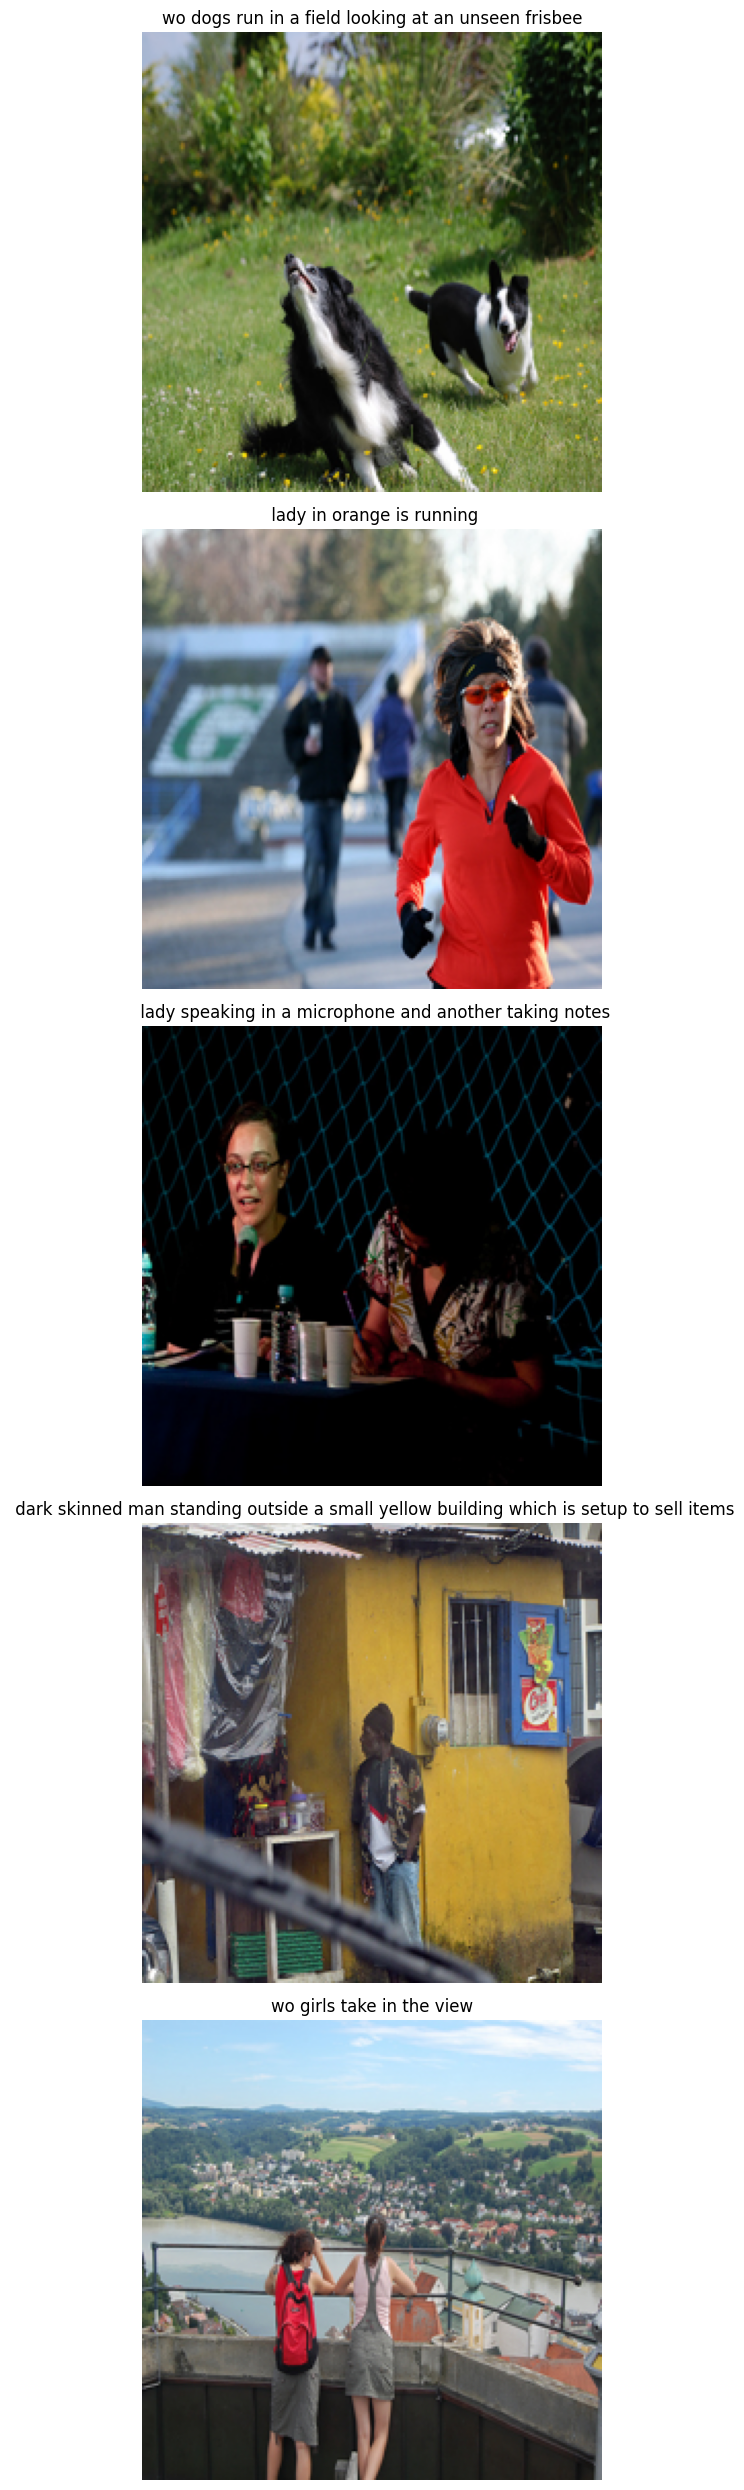

In [16]:
id_to_word = {v: k for k, v in word_to_id.items()}
plot_images_with_captions(train_pictures, train_captions, id_to_word)

#### scatter plot of caption lengths

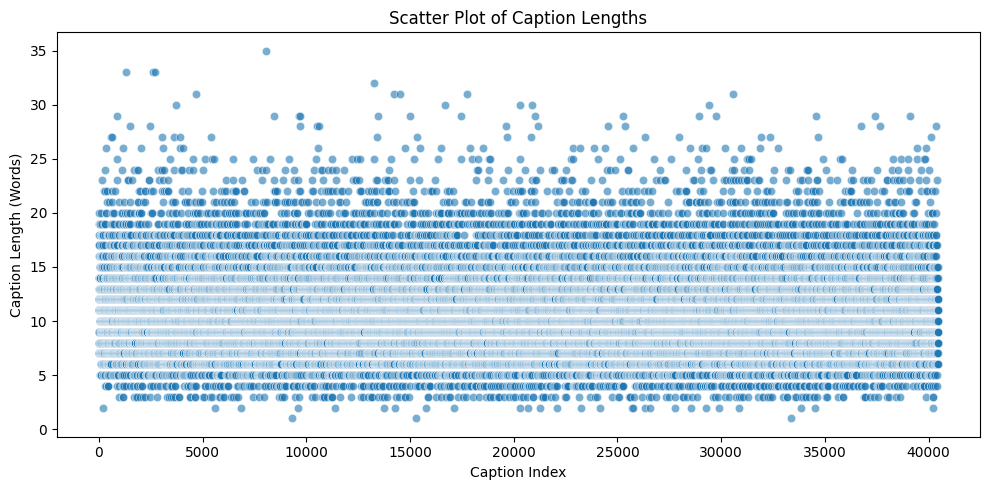

In [17]:
caption_lengths = []
for captions in captions_dict.values():
    for caption in captions:
        caption_lengths.append(len(caption.split()))  # Count words in caption
indices = range(len(caption_lengths))
plt.figure(figsize=(10, 5))
sns.scatterplot(x=indices, y=caption_lengths, alpha=0.6)
plt.xlabel("Caption Index")
plt.ylabel("Caption Length (Words)")
plt.title("Scatter Plot of Caption Lengths")
plt.tight_layout()
plt.show()

#### histogram of 20 most frequent words

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


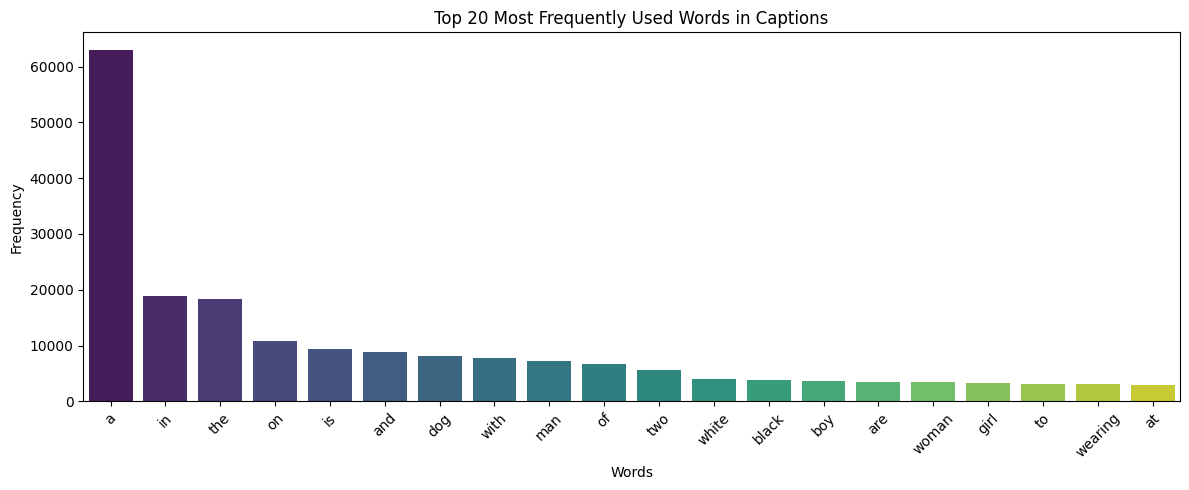

In [18]:
word_counter = Counter()
for captions in captions_dict.values():
    for caption in captions:
        words = caption.split()
        word_counter.update(words)
most_common_words = word_counter.most_common(20)
words, counts = zip(*most_common_words)
plt.figure(figsize=(12, 5))
sns.barplot(x=list(words), y=list(counts), palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title(f"Top {20} Most Frequently Used Words in Captions")
plt.tight_layout()
plt.show()

---

<a name="2"></a>
## 1 - CNN RNN Implementation

def cnn_rnn_model(vocab_size, embedding_dim, lstm_units, max_caption_len):
    # --- Encoder (CNN: EfficientNetB0) ---
    cnn_base = EfficientNetB0(include_top=False, weights="imagenet", pooling="avg")
    cnn_base.trainable = False
    image_input = Input(shape=(224, 224, 3), name="image_input")
    encoded_image = cnn_base(image_input)
    image_features = Dense(lstm_units, activation="relu", name="image_features")(encoded_image)
    # --- Decoder (RNN: LSTMs) ---
    caption_input = Input(shape=(max_caption_len,), name="caption_input")
    embeddings = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True, name="embedding")(caption_input)
    # Combine image features with LSTM inputs
    combined_input = Add(name="add_features")([tf.expand_dims(image_features, 1), embeddings])
    lstm_output = LSTM(lstm_units, return_sequences=True, name="lstm_1")(combined_input)
    lstm_output = LSTM(lstm_units, return_sequences=False, name="lstm_2")(lstm_output)
    # Output layer
    output = Dense(vocab_size, activation="softmax", name="output")(lstm_output)
    # --- Model ---
    model = Model(inputs=[image_input, caption_input], outputs=output, name="cnn_rnn_model")
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

vocab_size = 5000          # Example vocabulary size
embedding_dim = 256        # Word embedding size
lstm_units = 32           # Number of LSTM units
model = cnn_rnn_model(vocab_size, embedding_dim, lstm_units, caption_len)
model.summary()

---